# Kinematics and morphology for males and females

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from aging.plotting import (
    format_plots,
    save_factory,
    figure,
    PLOT_CONFIG,
    COLORMAPS,
)

In [2]:
%matplotlib inline

In [3]:
format_plots()
saver = save_factory(PLOT_CONFIG.save_path / "fig1-panels", tight_layout=False)

In [4]:
def compute_kinematics(df):
    mean_angular_speed = (df["angle"].diff(3) / 3).abs().mean() * 30
    mean_velocity = (
        df["velocity_2d_mm"]
        .rolling(3, center=True, min_periods=1, win_type="gaussian")
        .mean(std=0.5)
        .mean()
    ) * 30 / 100
    mean_3d_velocity = (
        df["velocity_3d_mm"]
        .rolling(3, center=True, min_periods=1, win_type="gaussian")
        .mean(std=0.5)
        .mean()
    ) * 30 / 100
    return pd.Series(dict(angular=mean_angular_speed, two_d=mean_velocity, three_d=mean_3d_velocity))


def compute_dist_to_center(df):
    center_x = (df['centroid_x_mm'].max() - df['centroid_x_mm'].min()) / 2
    center_y = (df['centroid_y_mm'].max() - df['centroid_y_mm'].min()) / 2

    distance_x = df['centroid_x_mm'] - center_x
    distance_y = df['centroid_y_mm'] - center_y

    dist_to_center = np.sqrt(distance_x ** 2 + distance_y ** 2)

    return pd.Series(dict(center_distance=dist_to_center.mean()))

In [5]:
agg_kin_df = []
agg_size_df = []

In [6]:
df = pd.read_parquet('ontogeny_males_syllable_df_v00.parquet')
df = df.query('age < 100')
kin_df = df.groupby(['age', 'uuid'], sort=False)[['angle', 'velocity_2d_mm', 'velocity_3d_mm']].apply(compute_kinematics)
_ddf = df.groupby(['age', 'uuid'], sort=False)[['centroid_x_mm', 'centroid_y_mm']].apply(compute_dist_to_center)
kin_df = kin_df.join(_ddf)
kin_df['exp'] = 'males'

agg_kin_df.append(kin_df)

size_df = df.groupby(['age', 'uuid'], sort=False)[['height_ave_mm', 'area_mm', 'width_mm']].mean()
size_df['area_mm'] = size_df['area_mm'] / 100
# size_df['exp'] = 'males'

agg_size_df.append(size_df)

In [7]:
df = pd.read_parquet('ontogeny_females_syllable_df_v00.parquet')
df = df.query('age < 100')
kin_df = df.groupby(['age', 'uuid'], sort=False)[['angle', 'velocity_2d_mm', 'velocity_3d_mm']].apply(compute_kinematics)
_ddf = df.groupby(['age', 'uuid'], sort=False)[['centroid_x_mm', 'centroid_y_mm']].apply(compute_dist_to_center)
kin_df = kin_df.join(_ddf)
kin_df['exp'] = 'females'
kin_df = kin_df.query('angular > 0.1')

In [8]:
agg_kin_df.append(kin_df)

In [9]:
size_df = df.groupby(['age', 'uuid'], sort=False)[['height_ave_mm', 'area_mm', 'width_mm']].mean()
size_df['area_mm'] = size_df['area_mm'] / 100
# size_df['exp'] = 'females'
size_df = size_df.query('area_mm > 1')
agg_size_df.append(size_df)

In [10]:
agg_kin_df = pd.concat(agg_kin_df)
agg_size_df = pd.concat(agg_size_df)

In [11]:
agg_df = agg_kin_df.join(agg_size_df)

In [12]:
# for female:
# Update age value to 52 for rows with uuid in the list
uuids = ['242bee8e-0ee7-45e7-8a13-678836a4cddb','d6f254af-d55a-427a-96e0-c452a233cbe2']

age_mapping = {
    93: 94,
    95: 94,
    97: 98,
    98: 98,
    102: 98,
    103: 105,
    105: 105,
    107: 105
}

agg_df.reset_index(inplace=True)
agg_df['age'] = agg_df['age'].map(age_mapping).fillna(agg_df['age'])
agg_df.loc[agg_df['uuid'].isin(uuids), 'age'] = 52
# Set the index back
agg_df.set_index(['age', 'uuid'], inplace=True)

In [13]:
mask = agg_df['area_mm'].isna()

In [14]:
agg_df[mask]

,,angular,two_d,three_d,center_distance,exp,height_ave_mm,area_mm,width_mm
age,uuid,,,,,,,,


In [15]:
ylabel_map = dict(
    angular="Angular speed (rad/s)", two_d="2D speed (cm/s)", three_d="3D speed (cm/s)", center_distance="Dist. to center (mm)",
    area_mm="Area (cm2)", height_ave_mm="Height (mm)", width_mm="Width (mm)",
)

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarn

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

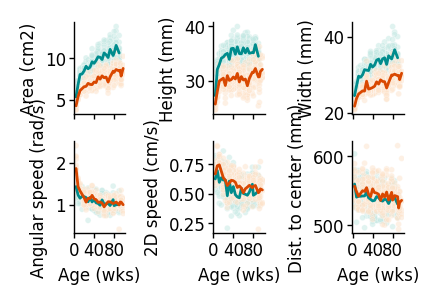

In [16]:
fig, ax = plt.subplots(2, 3, figsize=(2.1, 1.5), sharex=True)
for a, k in zip(ax.flat, ("area_mm", "height_ave_mm", "width_mm", "angular", "two_d", "center_distance")):
    a = sns.scatterplot(
        data=agg_df.reset_index(),
        x="age",
        y=k,
        hue='exp',
        linewidths='none',
        s=4.5,
        zorder=-1,
        palette=[COLORMAPS.ont_male(5), COLORMAPS.ont_female(5)],
        hue_order=['males', 'females'],
        ax=a,
        alpha=0.5,
        legend=False,
    )
    a = sns.lineplot(
        data=agg_df.reset_index(),
        x="age",
        y=k,
        hue='exp',
        errorbar=None,
        # err_kws=dict(lw=0, alpha=0.3),
        palette=[COLORMAPS.ont_male(255), COLORMAPS.ont_female(255)],
        hue_order=['males', 'females'],
        ax=a,
        #legend=k == "width_mm",
        legend=False,
    )
    a.set(ylabel=ylabel_map[k], xlabel="Age (wks)", xticks=[0, 40, 80])
sns.despine()
fig.tight_layout()

In [17]:
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig1"/ "mf-kinematics-and-morphology-over-age.pdf")

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

## stats

In [18]:
data=agg_df.reset_index()

In [19]:
#use all mice until 90 and remove age 16 to get only the ages in which we have data for both males and females:
data=data.query('age<91')
data=data.query('age!=16')

In [21]:
agg_df.to_csv('kinematics_ontogeny.csv', index=True)

In [22]:
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

def art_anova(data, dependent_var, factor1, factor2):
    """
    Perform Aligned Rank Transform (ART) ANOVA.
    
    Parameters:
    data (pd.DataFrame): The input data frame.
    dependent_var (str): The name of the dependent variable column.
    factor1 (str): The name of the first factor column.
    factor2 (str): The name of the second factor column.
    
    Returns:
    pd.DataFrame: The ANOVA results.
    """
    
    # Align the data
    align_data = data.copy()
    # Subtract the mean of each combination of factors from the dependent variable
    align_data[dependent_var] -= align_data.groupby([factor1, factor2])[dependent_var].transform('mean')
    
    # Rank the aligned data
    align_data['ranked_response'] = align_data[dependent_var].rank()
    
    # Fit an OLS model on the ranked data
    model = ols(f'ranked_response ~ {factor1} * {factor2}', data=align_data).fit()
    
    # Perform ANOVA on the fitted model
    anova_results = sm.stats.anova_lm(model, typ=2)
    
    # Convert results to a DataFrame
    anova_df = pd.DataFrame(anova_results)
    
    return anova_df

def tw_anova(data, dependent_var, factor1, factor2):
    """
    Perform two-way ANOVA.
    
    Parameters:
    data (pd.DataFrame): The input data frame.
    dependent_var (str): The name of the dependent variable column.
    factor1 (str): The name of the first factor column.
    factor2 (str): The name of the second factor column.
    
    Returns:
    pd.DataFrame: The ANOVA results.
    """
    
    # Align the data
    align_data = data.copy()
    align_data['ranked_response'] = align_data[[dependent_var]]
    # Fit an OLS model on the ranked data
    #model = ols(f'ranked_response ~ {factor1} * {factor2}', data=align_data).fit()
    model = ols(f'ranked_response ~ {factor1} * C({factor2})', data=align_data).fit()

    # Perform ANOVA on the fitted model
    anova_results = sm.stats.anova_lm(model, typ=3)
    
    # Convert results to a DataFrame
    anova_df = pd.DataFrame(anova_results)
    
    return anova_df

def ow_anova(data, dependent_var, factor1, factor2):
    """
    Perform two-way ANOVA.
    
    Parameters:
    data (pd.DataFrame): The input data frame.
    dependent_var (str): The name of the dependent variable column.
    factor1 (str): The name of the first factor column.
    factor2 (str): The name of the second factor column.
    
    Returns:
    pd.DataFrame: The ANOVA results.
    """
    
    # Align the data
    align_data = data.copy()
    align_data['ranked_response'] = align_data[[dependent_var]]
    # Fit an OLS model on the ranked data
    model = ols(f'ranked_response ~ {factor1}', data=align_data).fit()
    # Perform ANOVA on the fitted model
    anova_results = sm.stats.anova_lm(model, typ=3)
    
    # Convert results to a DataFrame
    anova_df = pd.DataFrame(anova_results)
    
    return anova_df

In [25]:
# Initialize variables
results = []
dependent_vars = ["angular", "two_d", "center_distance", "area_mm", "height_ave_mm", "width_mm"]
n_tests = len(dependent_vars)  # Number of ANOVA tests

# Perform ANOVA for each dependent variable
for i, k in enumerate(dependent_vars):
    print(k)
    anova_results = tw_anova(data, k, 'age', 'exp')
    anova_results['Dependent Variable'] = k  # Add dependent variable to the results
    results.append(anova_results)
    print(tabulate(anova_results, headers='keys', tablefmt='psql'))

# Combine results into a DataFrame
results_df = pd.concat(results).reset_index()
results_df.rename(columns={'index': 'Parameter'}, inplace=True)

# Move the 'Dependent Variable' column to the first position
cols = ['Dependent Variable'] + [col for col in results_df.columns if col != 'Dependent Variable']
results_df = results_df[cols]

# Apply Bonferroni correction to the p-values
results_df['Bonferroni_corrected_p'] = results_df['PR(>F)'] * n_tests
results_df['Bonferroni_corrected_p'] = results_df['Bonferroni_corrected_p'].apply(lambda p: min(p, 1))  # p-values should not exceed 1

# Save DataFrame to CSV file
results_df.to_csv('anova_results_kinematics.csv', index=False)

print("ANOVA results with Bonferroni-corrected p-values have been saved to 'anova_results.csv'")

angular
+------------+------------+------+-----------+---------------+----------------------+
|            |     sum_sq |   df |         F |        PR(>F) | Dependent Variable   |
|------------+------------+------+-----------+---------------+----------------------|
| Intercept  | 143.856    |    1 | 5849.58   |   0           | angular              |
| C(exp)     |   0.951357 |    1 |   38.6847 |   8.83385e-10 | angular              |
| age        |   6.45417  |    1 |  262.444  |   5.9109e-50  | angular              |
| age:C(exp) |   0.565169 |    1 |   22.9813 |   2.02229e-06 | angular              |
| Residual   |  16.2557   |  661 |  nan      | nan           | angular              |
+------------+------------+------+-----------+---------------+----------------------+
two_d
+------------+------------+------+------------+----------------+----------------------+
|            |     sum_sq |   df |          F |         PR(>F) | Dependent Variable   |
|------------+------------+------+--